In [2]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from keras.models import load_model
from collections import deque

# Cargar el modelo YOLO para pose estimation
modelo_yolo = YOLO('D:/InteligenciaArtificial3/Modelos/yolo11n-pose.pt')

# Cargar el modelo LSTM entrenado
modelo_lstm = load_model("D:/InteligenciaArtificial3/Modelos/pruebas_multi/lstm4-model4pm.h5")

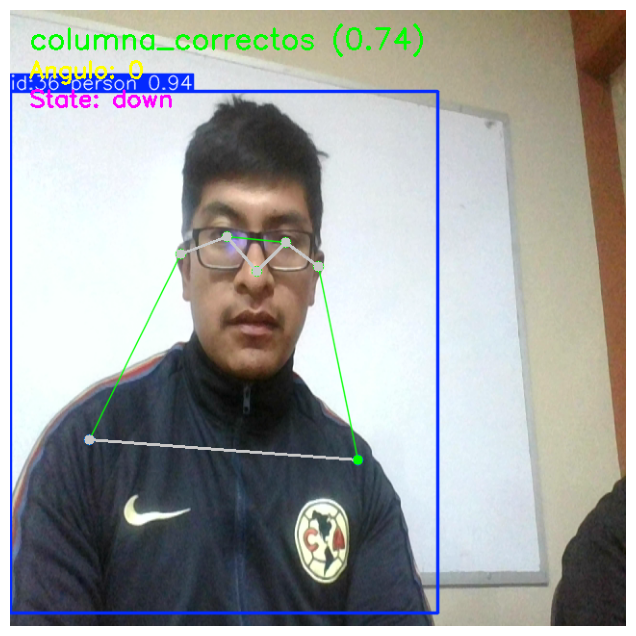


0: 640x640 1 person, 60.5ms
Speed: 4.9ms preprocess, 60.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 1 person, 60.5ms
Speed: 4.9ms preprocess, 60.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [ ]:
from collections import deque
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Parámetros principales
no_of_timesteps = 30
buffer = deque(maxlen=no_of_timesteps)
window_size = (640, 640)

# Conexiones del esqueleto (pares de keypoints) – 0-base (para YOLOPose)
skeleton = [
    [0, 1], [0, 2], [1, 3], [2, 4],
    [5, 6], [5, 7], [6, 8], [7, 9],
    [8, 10], [5, 11], [6, 12], [11, 12],
    [11, 13], [12, 14], [13, 15], [14, 16]
]

# Puntos de interés para peso muerto (sólo lado izquierdo)
# 5: hombro izq, 11: cadera izq, 13: rodilla izq
target_points = [5, 11, 13]

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    norm_ba, norm_bc = np.linalg.norm(ba), np.linalg.norm(bc)
    if norm_ba == 0 or norm_bc == 0:
        return 0
    cosine = np.dot(ba, bc) / (norm_ba * norm_bc)
    cosine = np.clip(cosine, -1.0, 1.0)
    return np.degrees(np.arccos(cosine))

def procesar_frame(frame, modelo_yolo):
    frame_resized = cv2.resize(frame, window_size)
    results = modelo_yolo.track(frame_resized, persist=True)
    if not results or not results[0].boxes:
        return None, frame_resized, None

    # Selecciona la detección de persona con mayor área
    best_idx, best_area = None, 0
    for idx, box in enumerate(results[0].boxes.xyxy):
        x1, y1, x2, y2 = box.cpu().numpy()
        area = (x2 - x1) * (y2 - y1)
        if area > best_area:
            best_area, best_idx = area, idx

    if best_idx is None:
        return None, frame_resized, None

    keypoints = results[0].keypoints[best_idx].xyn.cpu().numpy().flatten()
    keypoints_orig = results[0].keypoints[best_idx].xy.data.cpu().numpy()[0]
    output_frame = results[0].plot()
    return (keypoints, keypoints_orig), output_frame, results

def predecir(buffer, modelo_lstm):
    if len(buffer) < no_of_timesteps:
        return None, None
    secuencia = np.array(buffer).reshape(1, no_of_timesteps, -1)
    try:
        pred_proba = modelo_lstm.predict(secuencia)[0]
        label_index = np.argmax(pred_proba)
        confianza = pred_proba[label_index]
        label_mapping = {
            0: "columna_incorrectos",
            1: "columna_correctos",
            2: "extension_incorrectos",
            3: "extension_correctos"
        }
        clase = label_mapping[label_index]
        return clase, confianza
    except Exception as e:
        print(f"Error al predecir: {e}")
        return None, None

def dibujar_esqueleto_personalizado(frame, kps_coords, kps_scores, clase):
    threshold_conf = 0.2
    min_coord = 5

    # Color según clase
    if clase and "correctos" in clase:
        color_target = (0, 255, 0)
    elif clase and "incorrectos" in clase:
        color_target = (0, 0, 255)
    else:
        color_target = (255, 255, 255)

    # Dibuja conexiones
    for start_i, end_i in skeleton:
        s_score, e_score = kps_scores[start_i], kps_scores[end_i]
        s_pt, e_pt = kps_coords[start_i], kps_coords[end_i]
        if (s_score < threshold_conf or e_score < threshold_conf or
            (s_pt[0] < min_coord and s_pt[1] < min_coord) or
            (e_pt[0] < min_coord and e_pt[1] < min_coord)):
            continue
        p1 = tuple(map(int, s_pt))
        p2 = tuple(map(int, e_pt))
        line_color = color_target if {start_i, end_i} <= set(target_points) else (200, 200, 200)
        cv2.line(frame, p1, p2, line_color, 2)

    # Dibuja puntos
    for idx, pt in enumerate(kps_coords):
        score = kps_scores[idx]
        if score < threshold_conf or (pt[0] < min_coord and pt[1] < min_coord):
            continue
        x, y = int(pt[0]), int(pt[1])
        pt_color = color_target if idx in target_points else (200, 200, 200)
        cv2.circle(frame, (x, y), 5, pt_color, -1)

    return frame

# Estado inicial del deadlift
estado = "up"

# Selección de fuente
opcion = input("¿Usar (1) un video, o (2) la cámara en tiempo real? [1/2]: ")
if opcion == "1":
    ruta_video = input("Ruta del video: ")
    cap = cv2.VideoCapture(ruta_video)
    window_name = "Video"
elif opcion == "2":
    cap = cv2.VideoCapture(0)
    window_name = "Cámara"
else:
    print("Opción inválida")
    exit()

# Bucle principal
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    procesado, output_frame, results = procesar_frame(frame, modelo_yolo)
    if procesado is not None:
        keypoints, keypoints_orig = procesado
        buffer.append(keypoints)

        # Ángulo hombro-cadera-tobillo izquierdo
        try:
            a = keypoints_orig[5]   # hombro izq
            b = keypoints_orig[11]  # cadera izq
            c = keypoints_orig[15]  # tobillo izq
            angle = calculate_angle(a, b, c)
        except Exception as e:
            print(f"Error al calcular ángulo: {e}")
            angle = None

        if angle is not None:
            cv2.putText(output_frame, f"Angulo: {int(angle)}", (20, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            # Ajustar umbrales para deadlift
            if angle < 120:
                estado = "down"
            elif angle > 160:
                estado = "up"
        cv2.putText(output_frame, f"State: {estado}", (20, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 255), 2)

        # Predicción multiclase
        if len(buffer) >= no_of_timesteps:
            clase, confianza = predecir(buffer, modelo_lstm)
            if clase:
                texto = f"{clase} ({confianza:.2f})"
                color_txt = (0, 255, 0) if "correctos" in clase else (0, 0, 255)
                cv2.putText(output_frame, texto, (20, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color_txt, 2)
        else:
            clase = None

        # Extraer scores
        if keypoints.shape[0] == 34:
            kps_scores = np.ones(17)
        else:
            kps_scores = keypoints.reshape(-1, 3)[:, 2]

        # Dibujo del esqueleto
        output_frame = dibujar_esqueleto_personalizado(
            output_frame, keypoints_orig, kps_scores, clase)

        # Mensajes de corrección
        if clase == "columna_incorrectos":
            cv2.putText(output_frame, "error: columna incorrecta", (20, 140),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            cv2.putText(output_frame, "correccion: enrectar la espalda", (20, 170),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        elif clase == "extension_incorrectos":
            cv2.putText(output_frame, "error: extension incorrecta", (20, 140),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            cv2.putText(output_frame, "correccion: hombros no sobrepasen la cadera", (20, 170),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    else:
        output_frame = frame

    # Mostrar el frame en el notebook
    output_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(output_rgb)
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

    # Salir con 'q' (no es posible en notebook, así que puedes interrumpir la celda manualmente)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
# cv2.destroyAllWindows()